In [16]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'a30362a632374b498e8f2bcad0811e32')

In [17]:
from fastbook import *
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [18]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [19]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

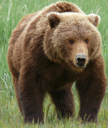

In [20]:
im = Image.open(dest)
im.to_thumb(128,128)

In [1]:
1+1

2

In [2]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'a30362a632374b498e8f2bcad0811e32')

from fastbook import *
bear_types = 'grizzly','black','teddy'
path = Path('images/bears')
if not path.exists():
    path.mkdir()
for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))
fns = get_image_files(path)
fns

(#422) [Path('images/bears/black/009b0ec4-f58c-4fce-a1c4-f26edfc1d8ea.jpg'),Path('images/bears/black/016b06e0-f3ff-4d3e-a6bb-5d1ab72a7955.JPG'),Path('images/bears/black/0207a3b9-a9b9-417e-ac04-735f3d7198e0.jpg'),Path('images/bears/black/042a7670-2f1f-4a71-9d24-77ef7023b9b1.jpg'),Path('images/bears/black/0962852e-56fe-4f5d-9de0-e0fdb5321d99.jpg'),Path('images/bears/black/1000d051-0ab0-4991-8a52-934e6ad3d96f.jpg'),Path('images/bears/black/1061a230-07b5-4c7e-a7f4-00486edd4aa8.jpg'),Path('images/bears/black/11982769-6ab3-43a4-860b-fe0ecb768e96.jpg'),Path('images/bears/black/15e62e70-5517-4883-852b-c1c90af4bf37.jpg'),Path('images/bears/black/17a09a65-7704-49b7-b750-566949af8963.jpg')...]

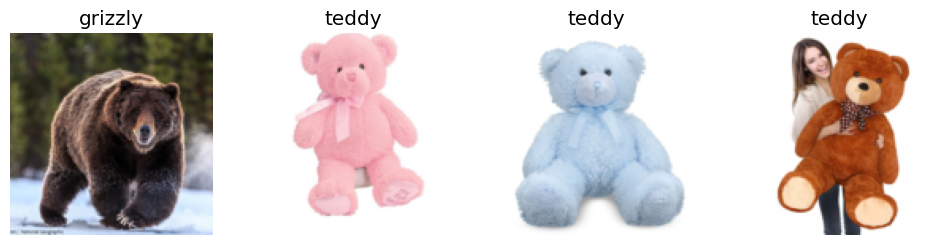

In [23]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [25]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\giabao/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:04<00:00, 10.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.348746,0.237827,0.074074,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.217136,0.166760,0.049383,01:00
1,0.149536,0.132000,0.037037,00:57
2,0.111500,0.130764,0.037037,00:56
3,0.088332,0.141041,0.037037,01:04


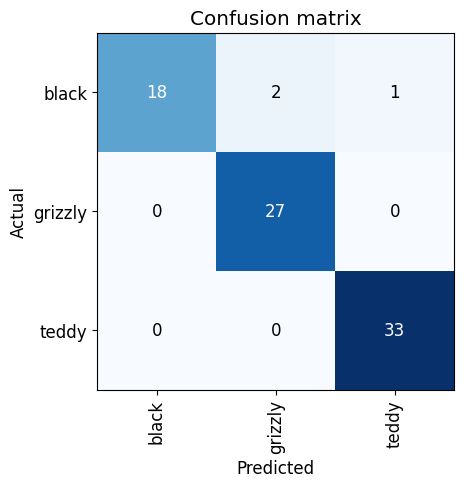

In [66]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

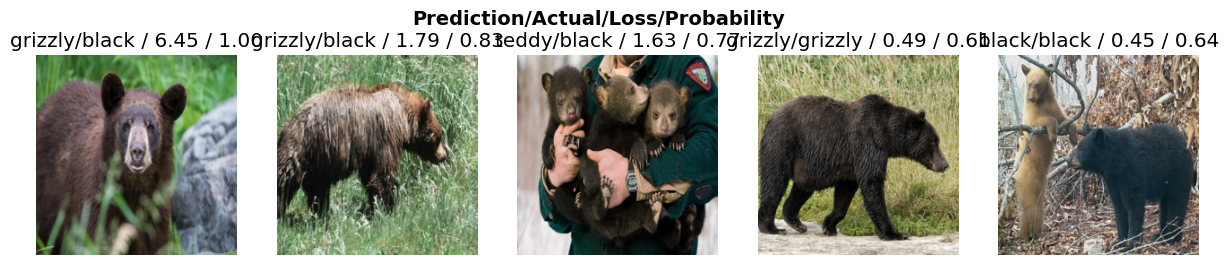

In [27]:
interp.plot_top_losses(5, nrows=1)

In [62]:
from fastai.vision.widgets import *
from ipywidgets import Button, HBox, Layout, VBox
cleaner = ImageClassifierCleaner(learn)
cleaner

In [61]:
import ipywidgets as widgets
from IPython.display import display

button = widgets.Button(description='Hello')
display(button)

Button(description='Hello', style=ButtonStyle())

In [64]:
from ipywidgets import Button, VBox
VBox([Button(description='button 1')])

In [65]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [67]:
learn.export()

In [68]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [69]:
learn_inf = load_learner(path/'export.pkl')

In [70]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([5.9977e-06, 9.9999e-01, 3.9699e-07]))

In [71]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [81]:
btn_upload = widgets.FileUpload()
btn_upload
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])
img = PILImage.create(btn_upload.data[-1])
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()

VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])